In [2]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline
from torchvision import transforms
from torchvision.utils import save_image
import torch.optim as optim
from torch.utils.data import Dataset
import pandas as pd
from PIL import Image
import os

In [3]:
batch_size = 64
block = 3 

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees = 0, translate=(0.1, 0.1)),
    transforms.ToTensor()]) 

transform_test = transforms.Compose(
    [transforms.ToTensor()]) # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

def changelabel(y, p):
    if torch.rand(1).item() > p:
        return y

    newy = torch.randint(0,9,[1]).item()
    if newy == y:
        newy = 9
    return newy
target_transform = transforms.Lambda(lambda y : changelabel(y,0.5))

torch.manual_seed(43)

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train, target_transform=target_transform)
train_dl = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=True, num_workers=2,
                                            prefetch_factor = 2, 
                                            pin_memory = True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
test_dl = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=False, num_workers=2,
                                             prefetch_factor = 2, 
                                            pin_memory = True)
val_dl = test_dl

Files already downloaded and verified
Files already downloaded and verified


In [4]:
is_cuda=torch.cuda.is_available()
device=torch.device("cuda" if is_cuda else "cpu")
print(device)

cuda


images.shape: torch.Size([64, 3, 32, 32])


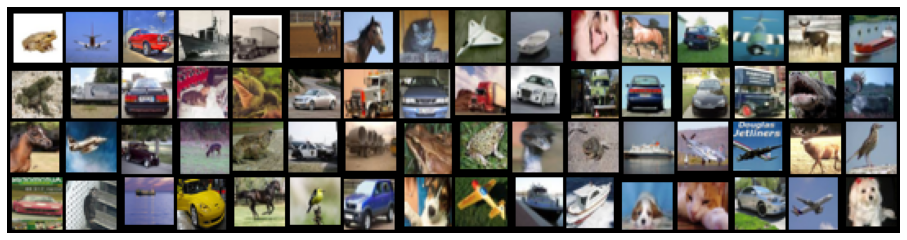

In [5]:
for images, _ in train_dl:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

images.shape: torch.Size([64, 3, 32, 32])


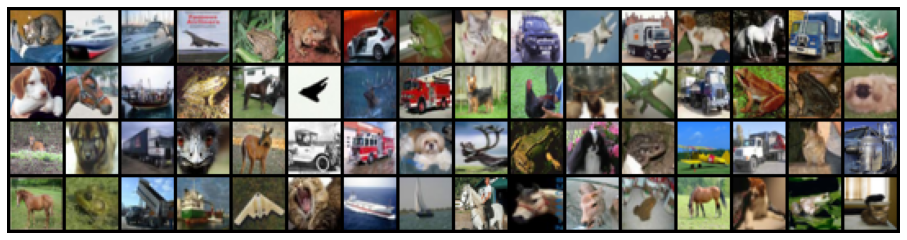

In [6]:
for images, _ in test_dl:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [7]:
from torch import Tensor
def sce(pred, labels, alpha, beta, num_classes, device):
    cross_entropy = torch.nn.CrossEntropyLoss()
    # CCE
    ce = cross_entropy(pred, labels)

    # RCE
    pred = F.softmax(pred, dim=1)
    pred = torch.clamp(pred, min=1e-7, max=1.0)
    label_one_hot = torch.nn.functional.one_hot(labels, num_classes).float().to(device)
    label_one_hot = torch.clamp(label_one_hot, min=1e-4, max=1.0)
    rce = (-1*torch.sum(pred * torch.log(label_one_hot), dim=1))

    # Loss
    loss = alpha * ce + beta * rce.mean()
    return loss
class SCELoss(torch.nn.Module):
    def __init__(self, alpha, beta, num_classes=10):
        super(SCELoss, self).__init__()
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.alpha = alpha
        self.beta = beta
        self.num_classes = num_classes
        self.cross_entropy = torch.nn.CrossEntropyLoss()

    def forward(self, pred, labels) -> Tensor:
        return sce(pred, labels, self.alpha, self.beta, self.num_classes, self.device)

In [8]:
class VGG(nn.Module):
    def __init__(self):
        super().__init__()

        # Set first filter  
        self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        
        # He initialization: 
        nn.init.kaiming_uniform_(self.conv1_1.weight, mode='fan_in', nonlinearity='relu')
        
        self.conv1_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv1_2.weight, mode='fan_in', nonlinearity='relu')

        # Set second filter 
        self.conv2_1 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv2_1.weight, mode='fan_in', nonlinearity='relu')
        
        self.conv2_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv2_2.weight, mode='fan_in', nonlinearity='relu')
        
        # Set third filter
        self.conv3_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv3_1.weight, mode='fan_in', nonlinearity='relu')
        
        self.conv3_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv3_2.weight, mode='fan_in', nonlinearity='relu')

        #nn.init.kaiming_uniform_(self.conv3_1.weight, mode='fan_in', nonlinearity='relu')
        
        self.pool = nn.MaxPool2d(2, 2)
        
        # Define proportion or neurons to dropout
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.4)
        self.dropout4 = nn.Dropout(0.5)

        # Definebatch Normalization
        self.BN1 = nn.BatchNorm2d(32)
        self.BN2 = nn.BatchNorm2d(64)
        self.BN3 = nn.BatchNorm2d(128)
        self.BN4 = nn.BatchNorm1d(128)
        
        if block is 1:
          self.fc1 = nn.Linear(8192, 120)
          self.fc2 = nn.Linear(120, 10) # CHANGE 
          self.fc3 = nn.Linear(84, 10)
        else:  
          self.fc1 = nn.Linear(2048, 128)
          nn.init.kaiming_uniform_(self.fc1.weight, mode='fan_in', nonlinearity='relu')
          self.fc2 = nn.Linear(128, 10) # CHANGE 

        

    def forward(self, x):
        if block is 1:  
          # 1 VGG block: 
          x = self.pool(F.relu(self.conv1_2(F.relu(self.conv1_1(x)))))
          x = torch.flatten(x, 1)
          x = F.relu(self.fc1(x))
          x = self.fc2(x)
        else:
          # 3 VGG block 
          x = self.pool(F.relu(self.BN1(self.conv1_2(F.relu(self.BN1(self.conv1_1(x)))))))
          x = self.dropout1(x)
          x = self.pool(F.relu(self.BN2(self.conv2_2(F.relu(self.BN2(self.conv2_1(x)))))))
          x = self.dropout2(x)
          x = self.pool(F.relu(self.BN3(self.conv3_2(F.relu(self.BN3(self.conv3_1(x)))))))
          x = self.dropout3(x)
          x = torch.flatten(x, 1) # flatten all dimensions except batch
          x = self.BN4(F.relu(self.fc1(x)))
          x = self.dropout4(x)
          x = self.fc2(x)


        #x = self.pool(F.relu(self.conv1_2(self.conv1_1(x))))
        #x = self.pool(F.relu(self.conv2_2(self.conv2_1(x))))

        #x = torch.flatten(x, 1) # flatten all dimensions except batch
        #x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        #x = self.fc3(x)
        return x


model = VGG() #to compile the model
model = model.to(device=device) #to send the model for training on either cuda or cpu
## Loss and optimizer
learning_rate = 0.001 #I picked this because it seems to be the most used by experts
load_model = True
# criterion = nn.CrossEntropyLoss()
criterion = SCELoss(0.1, 1)
optimizer = optim.SGD(model.parameters(), lr= learning_rate,momentum=0.9) #Adam seems to be the most popular for deep learning
#optimizer = optim.Adam(model.parameters(), lr = learning_rate)

# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [9]:
loss_store_train =[]
loss_store_val = []
acc_store=[]
epoches=100
xaxis=np.arange(0,epoches)

for epoch in range(epoches): #I decided to train the model for 50 epochs
    loss_ep = 0
    # model.train()
    for _, (data, targets) in enumerate(train_dl):
        data = data.to(device=device)
        targets = targets.to(device=device)
        ## Forward Pass
        optimizer.zero_grad()
        score = model(data)
        loss = criterion(score,targets)
        loss.backward()
        optimizer.step()
        # scheduler.step()
        loss_ep += loss.item()
    print(f"Loss in epoch {epoch}: {loss_ep/len(train_dl):.3f}")
    loss_store_train.append(loss_ep/len(train_dl))
    
    # model.eval()
    valid_loss = 0
    with torch.no_grad():
        num_correct = 0
        num_samples = 0
        for _, (data,targets) in enumerate(val_dl):
            data = data.to(device=device)
            targets = targets.to(device=device)
            ## Forward Pass
            score = model(data)
            _, predictions = score.max(1)
            loss2 = criterion(score,targets)
            valid_loss += loss2.item()
            
            num_correct += (predictions == targets).sum()
            num_samples += predictions.size(0)
        print(
            f"Got {num_correct} / {num_samples} with accuracy {float(num_correct) / float(num_samples) * 100:.2f}"
        )
        acc_store.append(float(num_correct) / float(num_samples) * 100)
    loss_store_val.append(valid_loss/len(test_dl))

Loss in epoch 0: 8.253
Got 3069 / 10000 with accuracy 30.69
Loss in epoch 1: 7.821
Got 3873 / 10000 with accuracy 38.73
Loss in epoch 2: 7.624
Got 4196 / 10000 with accuracy 41.96
Loss in epoch 3: 7.524
Got 4428 / 10000 with accuracy 44.28
Loss in epoch 4: 7.464
Got 4593 / 10000 with accuracy 45.93
Loss in epoch 5: 7.422
Got 4858 / 10000 with accuracy 48.58
Loss in epoch 6: 7.294
Got 5063 / 10000 with accuracy 50.63
Loss in epoch 7: 7.247
Got 5270 / 10000 with accuracy 52.70
Loss in epoch 8: 7.163
Got 5406 / 10000 with accuracy 54.06
Loss in epoch 9: 7.125
Got 5409 / 10000 with accuracy 54.09
Loss in epoch 10: 7.074
Got 5611 / 10000 with accuracy 56.11
Loss in epoch 11: 7.024
Got 5755 / 10000 with accuracy 57.55
Loss in epoch 12: 6.956
Got 5913 / 10000 with accuracy 59.13
Loss in epoch 13: 6.961
Got 6033 / 10000 with accuracy 60.33
Loss in epoch 14: 6.911
Got 6094 / 10000 with accuracy 60.94
Loss in epoch 15: 6.851
Got 6121 / 10000 with accuracy 61.21
Loss in epoch 16: 6.808
Got 6128 /

Text(0, 0.5, 'Accuracy')

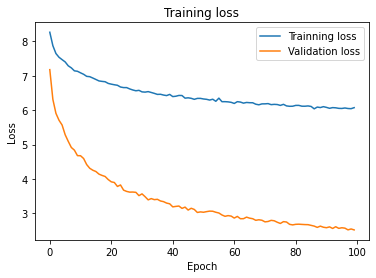

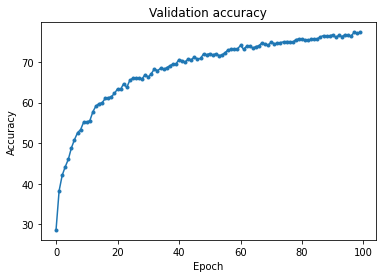

In [10]:
plt.figure(1)
plt.plot(loss_store_train,label = 'Trainning loss')
plt.plot(loss_store_val, label = 'Validation loss') 
plt.legend() 
plt.xlabel('Epoch') 
plt.ylabel('Loss')
plt.title('Training loss') 
plt.figure(2)
plt.plot(acc_store,marker='.')
plt.title('Validation accuracy') 
plt.xlabel('Epoch') 
plt.ylabel('Accuracy')

In [11]:
filename = 'contamination50sl'
PATH = './' + filename + '.pth'
torch.save(model.state_dict(), PATH)

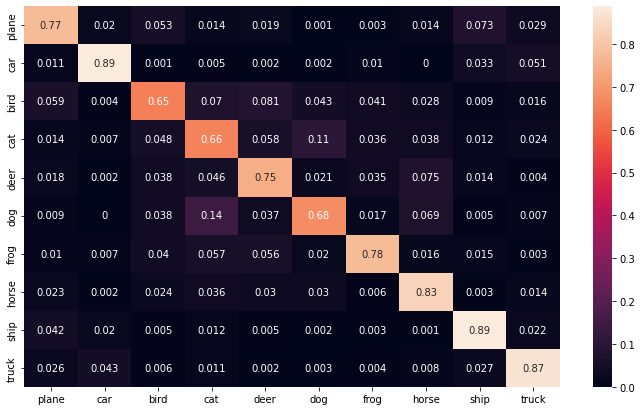

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for _, (data,targets) in enumerate(val_dl):
        data = data.to(device=device)
        targets = targets.to(device=device)
        score = model(data)
        
        output = (torch.max(torch.exp(score), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = targets.data.cpu().numpy()
        y_true.extend(labels) # Save Truth
        
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig(filename + '_confmat.png')

TypeError: Invalid shape (3, 274, 274) for image data

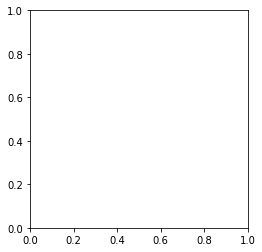

In [40]:
dataiter = iter(test_dl)
images, labels = dataiter.next()

# print images
plt.imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [41]:
net = VGG()
net.load_state_dict(torch.load(PATH))

outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_dl:
        images, labels = data
        # calculate outputs by running images through the network 
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(
        f"Accuracy of the network on the 10000 test images: {float(correct) / float(total) * 100:.2f}%"
)

NameError: name 'classes' is not defined